# 用户消费行为分析
### 目录
1. [项目介绍](#一项目介绍)
2. [数据预处理](#二数据预处理)
3. [用户整体消费趋势分析](#三用户整体消费趋势分析)
    1. 消费金额随月份变化趋势
    2. 不同地区消费总额比较
    3. 用户消费偏好的产品类别
4. [用户个体消费分析](#四用户个体消费分析)
    1. 金额与次数的统计
    2. 用户贡献度（累计消费金额占比）
5. [用户消费行为](#五用户消费行为)
    1. 首购时间
    2. 最后一次购买时间
    3. 用户分层
        1. 构建RFM模型
        2. 新&老、活跃、回流用户分析
    4. 购买周期
    5. 生命周期（新老客户消费比）
6. [复购率和回购率分析](#六复购率和回购率分析)
    1. 复购率分析
    2. 回购率分析
7. [结论](#七结论)

### 一、项目介绍


本项目将会基于某电商平台的用户所产生的56余万条数据对用户于2020.01.05~2020.11.21之间的消费行为进行分析。涉及数据预处理、数据可视化、RFM模型、统计学分析等技术与方法；内容主要包含用户的整体与个体分析、消费时间分析、用户分层、复购率与回购率分析、购买周期与生命周期分析等。

In [122]:
# 本项目使用到的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import plotly.express as px
import re
import plotly.graph_objects as go

### 二、数据预处理

In [123]:

%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format # id值过长，禁用科学计数法显示以防数值无法区分
plt.style.use('ggplot') #选用R的绘图库的风格
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 或者 ['SimSun']
plt.rcParams['axes.unicode_minus'] = False  # 处理负号显示问题

#导入数据并按照时间顺序排列
df=pd.read_csv('电子产品销售分析.csv')
df['event_time']=pd.to_datetime(df['event_time']) #转换时间格式方便后续操作

# 按时间顺序排列
df=df.sort_values(by='event_time')
df.head()

,Unnamed: 0,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
29038,32575,1970-01-01 00:33:40+00:00,2340103122686312699,2273948312304353950,2268105428166508800,electronics.smartphone,huawei,139,1515915625479406336,37,女,上海
37164,49718,1970-01-01 00:33:40+00:00,2348532547933176638,2273948246437003591,2268105458902368512,computers.peripherals.joystick,x-game,58,1515915625484433408,32,男,北京
37163,49707,1970-01-01 00:33:40+00:00,2348532546750382903,1515966223510204922,2268105412463034368,furniture.bedroom.pillow,mattel,3,1515915625484433408,32,男,北京
37162,49654,1970-01-01 00:33:40+00:00,2348532542077928224,1515966223509089400,2268105430162997248,electronics.audio.headphone,samsung,81,1515915625484433152,41,女,湖北
37161,49600,1970-01-01 00:33:40+00:00,2348532537111872263,1515966223509090246,2268105440455820032,NaN,vitek,42,1515915625484433152,41,女,湖北


In [124]:
# 初步的数据信息，检查是否有缺失值
df.info()

# 绘制按年分布的直方图
# plt.figure()
# plt.hist(df['event_time'],rwidth=0.8,color='c')
# plt.title('Ordering Year Distribution')
# plt.show()

print(len(df[df['event_time'].dt.year == 1970]))

<class 'pandas.core.frame.DataFrame'>
Index: 564169 entries, 29038 to 564168
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   Unnamed: 0     564169 non-null  int64              
 1   event_time     564169 non-null  datetime64[ns, UTC]
 2   order_id       564169 non-null  int64              
 3   product_id     564169 non-null  int64              
 4   category_id    564169 non-null  float64            
 5   category_code  434799 non-null  object             
 6   brand          536945 non-null  object             
 7   price          564169 non-null  float64            
 8   user_id        564169 non-null  float64            
 9   age            564169 non-null  float64            
 10  sex            564169 non-null  object             
 11  local          564169 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(4)
memory usage: 56.0+ MB
1307


In [125]:
# 检查是否有异常值
df.describe()

,Unnamed: 0,order_id,product_id,category_id,price,user_id,age
count,564169,564169,564169,564169,564169,564169,564169
mean,1792965,2370552375995612672,1695711382254004224,2272918541312721920,208,1515915625486186240,33
std,774534,20251377336958124,329068789815964928,21582815482152660,305,23770833,10
min,0,2294359932054536960,1515966223509088512,2268105388421284352,0,1515915625439951872,16
25%,1658965,2353294490766148096,1515966223509105152,2268105406691672832,23,1515915625467185664,24
50%,1861597,2376886093782974464,1515966223509262592,2268105428166508800,88,1515915625486696960,33
75%,2473370,2388440981134597632,1515966223530599168,2268105440044778496,278,1515915625511581440,42
max,2633520,2388440981134693888,2388434452476881920,2374498914001945600,18329,1515915625514891264,50


In [126]:
# 检查是否有重复值
df.duplicated().any()

False

初步观察数据，
1. category_code和brand有空值，通过删除包含空值的行进行清洗
2. 有1307条数据来自1970年，其余56万条均来自2020年。选择只保留2020年数据进行分析
3. Unnamed列为无义数据，删去
4. 判断不存在异常值与重复值 

将清洗过过后的表单保存为df0

In [127]:
# 只保留2020年数据
df0=df[df['event_time'].dt.year == 2020]

# 删除包含空值的行
df0.dropna(subset=['category_code', 'brand'], inplace=True)

# 删除无意义特征
df0 = df0.drop("Unnamed: 0", axis=1)

# 产出重复值
df0 = df0.drop_duplicates()

# 重新整理index
df0 = df0.reset_index(drop=True) 
df0.index=df0.index+1

df0.info()
df0

C:\Users\Suihua\AppData\Local\Temp\ipykernel_16104\1973424129.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419390 entries, 1 to 419390
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     419390 non-null  datetime64[ns, UTC]
 1   order_id       419390 non-null  int64              
 2   product_id     419390 non-null  int64              
 3   category_id    419390 non-null  float64            
 4   category_code  419390 non-null  object             
 5   brand          419390 non-null  object             
 6   price          419390 non-null  float64            
 7   user_id        419390 non-null  float64            
 8   age            419390 non-null  float64            
 9   sex            419390 non-null  object             
 10  local          419390 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(4)
memory usage: 35.2+ MB


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
1,2020-01-05 04:06:18+00:00,2348710347105370326,1515966223509088613,2268105430162997248,electronics.audio.headphone,apple,204,1515915625484572160,25,女,上海
2,2020-01-05 04:09:00+00:00,2348709909622685923,1515966223509127621,2268105406456792064,computers.notebook,microlab,28,1515915625484571648,25,男,海南
3,2020-01-05 04:35:21+00:00,2348710405431361995,1515966223509129592,2268105426983716096,construction.tools.screw,samsung,12,1515915625484572160,25,女,上海
4,2020-01-05 04:44:43+00:00,2348709879230758992,1515966223509259180,2268105389956400128,appliances.kitchen.washer,lg,579,1515915625484571648,25,男,海南
5,2020-01-05 04:56:26+00:00,2348710371440722247,1515966223509298224,2268105407144657920,accessories.bag,rivacase,29,1515915625484572160,25,女,上海
...,...,...,...,...,...,...,...,...,...,...,...
419386,2020-11-21 10:08:54+00:00,2388440981134693941,1515966223509088622,2374498914000592384,electronics.video.tv,lg,370,1515915625513809920,25,女,上海
419387,2020-11-21 10:10:01+00:00,2388440981134693942,1515966223526602848,2268105428166508800,electronics.smartphone,oppo,139,1515915625514888704,21,男,上海
419388,2020-11-21 10:10:13+00:00,2388440981134693943,1515966223509089282,2268105428166508800,electronics.smartphone,apple,419,1515915625514891264,21,女,北京
419389,2020-11-21 10:10:30+00:00,2388440981134693944,1515966223509089917,2268105402447036928,appliances.personal.scales,vitek,12,1515915625514834176,19,女,上海


### 三、用户整体消费趋势分析

#### 1. 按月份分组用户，统计消费金额并绘制折线图用以分析趋势

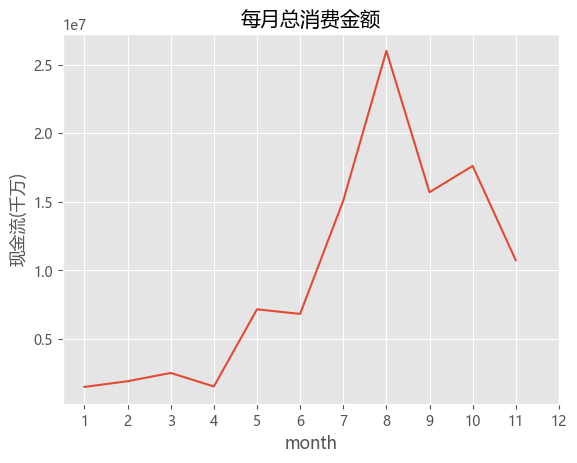

In [128]:
#添加month列，用以之后创建分组
df0['month'] = df0['event_time'].dt.month

plt.figure()
df0.groupby(by='month')['price'].sum().plot()
plt.xticks(np.linspace(1,12,12).astype(int))
plt.ylabel('现金流(千万)')
plt.title('每月总消费金额');

##### 分析：
1. 上半年的月消费总金额较低，于6月开始有剧烈增长并于8月达到峰值，年末再次下降。可能平台在暑期有促销活动，也可能与季节性因素等等相关。具体的成因分析需要更多有关该电商平台的业务信息。

#### 2. 不同地区消费总额比较

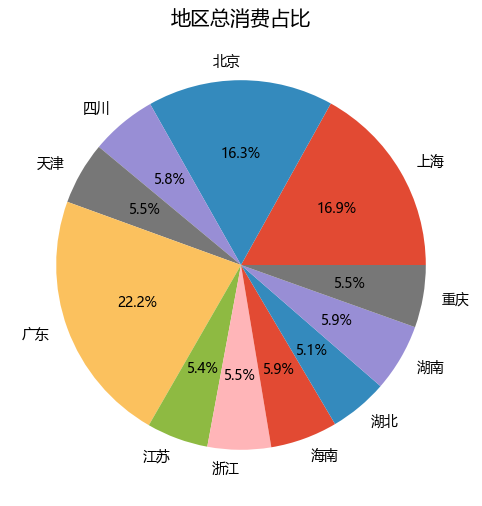

In [129]:
# 各个地区用户的消费金额
location_amount = df0.groupby('local')['price'].sum()
plt.figure(figsize=(8, 6))
plt.pie(location_amount, labels=location_amount.index, autopct='%1.1f%%')
plt.title('地区总消费占比')
plt.show()


##### 分析
2. 广东、北京、上海的消费相较于其他地区十分突出。可以以此为起点依据更多平台的数据信息深挖潜在变量，以帮助平台优化区域定位和市场拓展策略；还可以针对高消费的区域加大市场投入、提升推广力度、进行本地化适配等。

#### 3. 用户消费偏好的产品类别
统计用户的消费类别分布，绘制饼图。如果某一些类别的消费金额的占比小于2%则统一划分到一个名为others的区块内

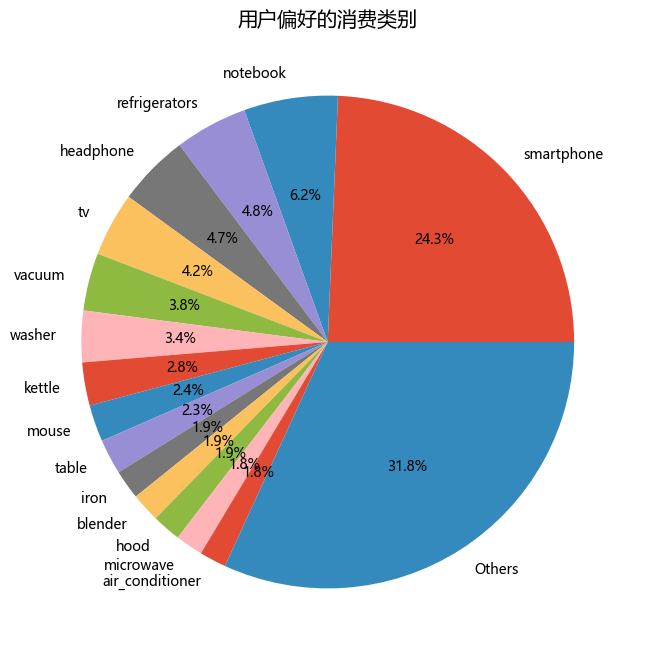

In [130]:
# 提取用户偏好的前15个category_code
# 其余类别消费占比一定小于2%。 折叠为'Others'区块
top_categories = df0['category_code'].value_counts().head(15).index.tolist()
other_category = 'Others'
other_count = df0.loc[~df0['category_code'].isin(top_categories), 'category_code'].count()

# 创建一个新的DataFrame，包含前五个category_code和其他类别的数量
category_counts = df0.loc[df0['category_code'].isin(top_categories), 'category_code'].value_counts().to_frame()
category_counts.columns = ['count']
category_counts.loc[other_category] = other_count

# 在饼图上只显示category_code中最细的子分类
extracted_categories = [re.sub('.*\.', '', category) for category in category_counts.index]

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(category_counts['count'], labels=extracted_categories, autopct='%1.1f%%')
plt.title('用户偏好的消费类别')
plt.show()


##### 分析：
3. 手机、冰箱、笔记本电脑、耳机、电视作为前五类别，可以帮助平台建立用户画像。在娱乐、办公、音频体验和家居产品领域，平台首先需要确保该类别业务链的稳定性，同时可以考虑扩大产品种类、加强这产品宣传和推广与促销活动以吸引更多的潜在消费者
4. 与冰箱相比，同样是大型家居类产品的空调、桌子、抽油烟机等销量仅为前者一半左右。需要对原因进行更深入的分析，可能与市场的竞争与饱、平台选择的的合作品牌等因素相关联。

### 四、用户个体消费分析

#### 1. 金额与次数的统计
创建基于原表单（df0）对'user_id'进行分组的新表单user_ind, 并统计'total_price', 'total_orders'作为新列，其中:  
'total_price'为每位用户的总消费金额  
'total_orders'为每位用户的总消费次数  

In [131]:
user_ind = df0.groupby('user_id').agg({'price': 'sum', 'order_id': 'count'}).reset_index()
user_ind.columns = ['user_id', 'total_price', 'total_orders']

print(user_ind.describe())

# # 计算一下最高的那25%用户承担了多少金额
# total_amount = user_ind['total_price'].sum() 
# amount_greater_than_1151 = user_ind[user_ind['total_price'] > 1151]['total_price'].sum()
# percentage = (amount_greater_than_1151 / total_amount) * 100
# percentage

                  user_id  total_price  total_orders
count               86916        86916         86916
mean  1515915625478070528         1227             5
std              22999442         3835            20
min   1515915625439951872            0             1
25%   1515915625457501184          171             1
50%   1515915625477805568          472             2
75%   1515915625498022144         1151             4
max   1515915625514891264       145811           744


##### 分析：
1. 每位用户的消费总额平均值为1127，中位数为472，属于右偏分布。
2. 75%分位数为1151（与平均数相近）有1/4的高额消费用户承担了77%的总消费额


#### 2. 用户贡献度（累计消费金额占比）

Text(0.5, 1.0, 'p.d.f')

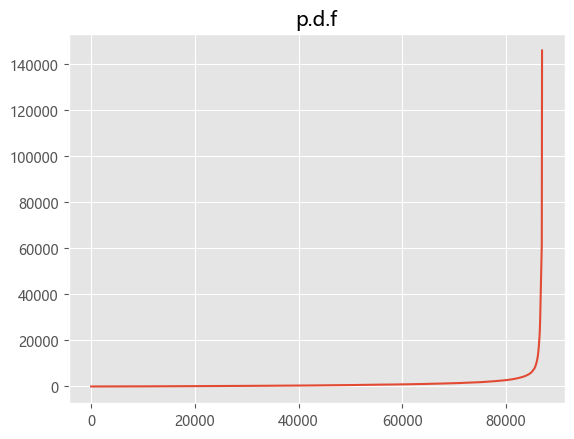

In [132]:
# 先来看看消费金额的pdf函数图像
total_price_asc = user_ind['total_price'].sort_values()
user = np.linspace(1,86916,86916)

plt.plot(user, total_price_asc)
plt.title('p.d.f')

Text(0.5, 1.0, 'c.d.f')

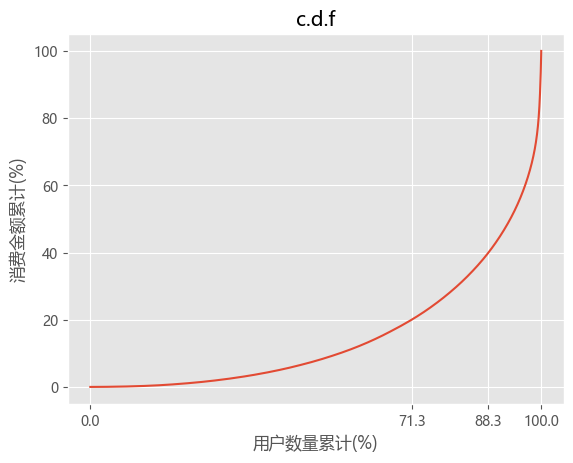

In [133]:
# 为了观察贡献度，转换为cdf函数
acc_price=user_ind['total_price'].sort_values().cumsum().tolist()
acc_price_prop=[100*x/acc_price[-1] for x in acc_price]
user_prop = np.linspace(0,100,86916)


plt.plot(user_prop,acc_price_prop)
# 标记刚好使得cdf为20%和40%的用户index（找出cdf距离最近的值，并取其index标记在x轴）
marker_02 = acc_price_prop.index(min(acc_price_prop, key=lambda x: abs(x - 20)))
marker_04 = acc_price_prop.index(min(acc_price_prop, key=lambda x: abs(x - 40)))
plt.xticks([0,marker_02/869.16,marker_04/869.16,100])
plt.xlabel('用户数量累计(%)')
plt.ylabel('消费金额累计(%)')
plt.title('c.d.f')

##### 分析
3. 前88.3%的用户贡献了40%的金额，后11.7%的高消费用户贡献了60%的金额。少数用户贡献了平台的主要现金流，需要重点关注

### 五、用户消费行为

#### 1. 首购时间


<Axes: xlabel='order_date'>

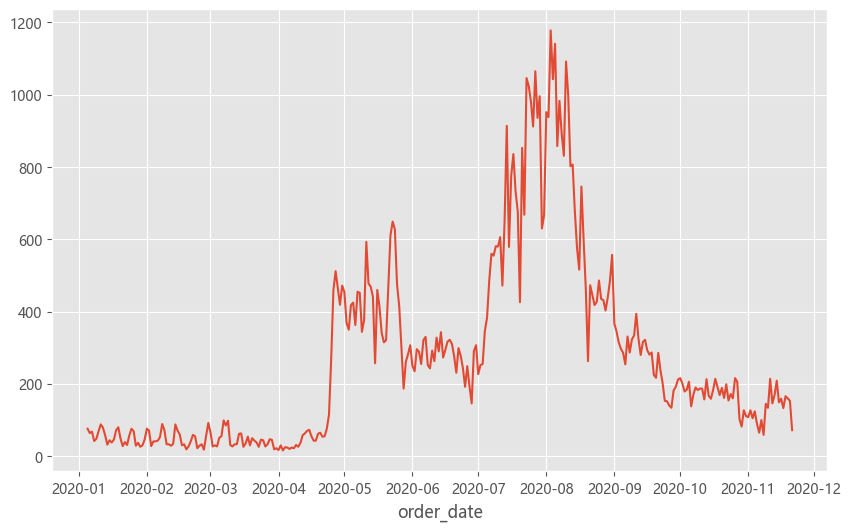

In [134]:
# 将时间精确到天
df0['order_date'] = df0['event_time'].dt.date.tolist()

plt.figure(figsize=(10,6))
df0.groupby(by='user_id')['order_date'].min().value_counts().plot()

##### 分析
1. 新用户流入在1月至4月下旬很少，在5-6月发生了一次小增长，随后6-7又有相当幅度的下降。随后在7月至8月中旬有一次爆发式的用户流入，并且在之后逐渐降低。数据变化剧烈、人为痕迹明显，应该不是自然因素，推测平台在5月和7月采取了某些措施。

#### 2. 最后一次购买时间


<Axes: xlabel='order_date'>

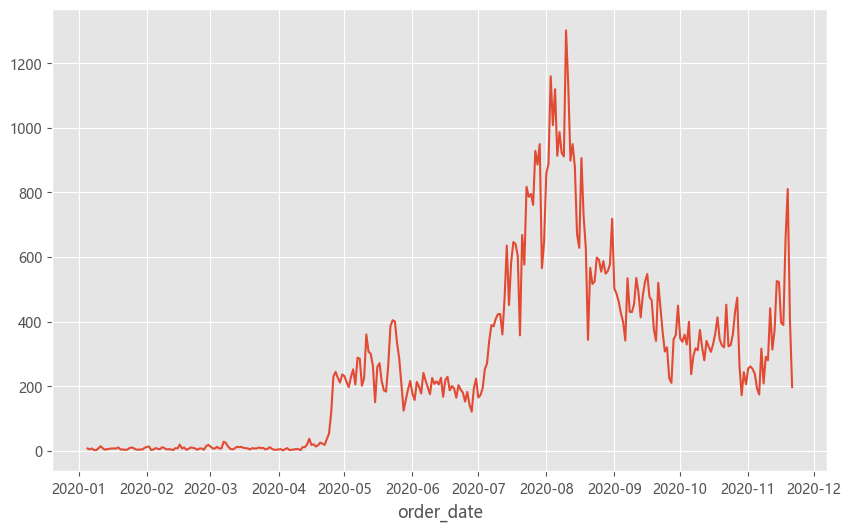

In [135]:
plt.figure(figsize=(10,6))
df0.groupby(by='user_id')['order_date'].max().value_counts().plot()

##### 分析
2. 在数据截止前（11月底）有突出峰值，说明大概率存在可观数量的用户在持续消费直到数据截止。判断平台有一批忠诚客户
3. 大量客户最后一次消费发生在5-6月和7-8月的两次新用户爆发式流入的事件中，说明这两次次事件并未创造足够的用户黏性、需要采取措施。

#### 3. 用户分层

##### 1. 构建RFM模型  
![Source:Cheers快樂工作人](./RFM.jpg)

In [136]:
rfm = df0.pivot_table(index='user_id',
                    values=['order_date','order_id','price'],
                    aggfunc={
                        'order_date':'max',  # 最后一次购买
                        'order_id':'count',  # 总订单数/总天数即为频率，因此以总订单数进行分析
                        'price':'sum',   # 消费总金额
                    })
                    
#每个用户最后一次购买到数据截止日期的天数
rfm['R'] = -(rfm['order_date'] - rfm['order_date'].max())/np.timedelta64(1,'D')

# 定义F和M
rfm.rename(columns={'order_id':'F','price':'M'},inplace=True)
rfm.head()

,order_date,F,M,R
user_id,,,,
1515915625439951872,2020-07-09,1,417,135
1515915625440038400,2020-10-28,2,56,24
1515915625440051712,2020-11-16,12,5985,5
1515915625440099840,2020-10-06,6,3647,46
1515915625440121600,2020-07-14,2,183,130


In [137]:
# 每个数据减去数据所在列的平均值，根据结果值与1作比较，如果>0，设置为1，否则为0
# 注意'R'数据越小则越靠前，因此如果<0，设置为1，否则为0
d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
    }

def rfm_func(x):  # x输入三整列数据,每一组RFM值都返回一个用户类别
    level_R = '1' if x['R'] < 0 else '0'
    level_F = '1' if x['F'] > 0 else '0'
    level_M = '1' if x['M'] > 0 else '0'
    label = level_R + level_F + level_M
    return d[label]


rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1) # axis=1 向右逐步取列
rfm

,order_date,F,M,R,label
user_id,,,,,
1515915625439951872,2020-07-09,1,417,135,一般挽留客户
1515915625440038400,2020-10-28,2,56,24,一般发展客户
1515915625440051712,2020-11-16,12,5985,5,重要价值客户
1515915625440099840,2020-10-06,6,3647,46,重要价值客户
1515915625440121600,2020-07-14,2,183,130,一般挽留客户
...,...,...,...,...,...
1515915625514887424,2020-11-21,1,208,0,一般发展客户
1515915625514887936,2020-11-21,1,3472,0,重要发展客户
1515915625514888704,2020-11-21,2,278,0,一般发展客户


In [138]:
# 平移数据以将均值点设置为原点,一个centralization的概念
rfm_centralized = rfm[['R','F','M']].apply(lambda x:x-x.mean())
rfm_centralized['label']=rfm['label']

rfm_centralized

,R,F,M,label
user_id,,,,
1515915625439951872,35,-4,-811,一般挽留客户
1515915625440038400,-76,-3,-1171,一般发展客户
1515915625440051712,-95,7,4758,重要价值客户
1515915625440099840,-54,1,2420,重要价值客户
1515915625440121600,30,-3,-1044,一般挽留客户
...,...,...,...,...
1515915625514887424,-100,-4,-1019,一般发展客户
1515915625514887936,-100,-4,2245,重要发展客户
1515915625514888704,-100,-3,-950,一般发展客户


In [160]:
labels = rfm['label'].unique()

# 把颜色设成和上面的RFM图一样
color_mapping = {
    '重要价值客户': 'rgb(188, 85, 236)',  
    '重要保持客户': 'rgb(241, 105, 203)',  
    '重要发展客户': 'rgb(229, 73, 112)',  
    '重要挽留客户': 'rgb(19, 80, 195)',  
    '一般价值客户': 'rgb(115, 219, 106)',  
    '一般保持客户': 'rgb(58, 153, 207)',  
    '一般发展客户': 'rgb(230, 199, 168)',  
    '一般挽留客户': 'rgb(177, 235, 207)'
}

# 选了一个比较方便看的角度存成图片了。如果想自己转一转图观察的话可以运行下面的代码
# fig = px.scatter_3d(rfm_centralized, x='F', y='R', z='M', color='label',color_discrete_map=color_mapping)
# fig.update_layout(scene=dict(xaxis_title='F', yaxis_title='R', zaxis_title='M'))
# fig.show()

![RMF-3dscatter](./RMF-3dscatter.png)

In [140]:
# 看看不同层级用户人数的占比
label_counts = rfm['label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

# 绘制饼图
fig = go.Figure(data=[go.Pie(labels=label_percentages.index, values=label_percentages.values, textinfo='label+percent')])
fig.update_layout(title='不同层级用户的人数占比', showlegend=False)
fig.show()

##### 2. 新&老、活跃、回流用户分析


In [141]:
df0['Month']=df0['event_time'].dt.month
df0['Day']=df0['event_time'].dt.date

pivoted_counts = df0.pivot_table(
index='user_id',
columns='Month',
values='Day',
aggfunc='count').fillna(0)
pivoted_counts

Month,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1515915625439951872,0,0,0,0,0,0,1,0,0,0,0
1515915625440038400,0,0,0,0,0,0,0,0,1,1,0
1515915625440051712,0,0,0,0,0,0,0,0,0,3,9
1515915625440099840,0,0,0,0,0,1,1,0,3,1,0
1515915625440121600,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1515915625514887424,0,0,0,0,0,0,0,0,0,0,1
1515915625514887936,0,0,0,0,0,0,0,0,0,0,1
1515915625514888704,0,0,0,0,0,0,0,0,0,0,2


In [142]:
# 转化为0-1矩阵：1代表有过消费记录，0代表没有
df_purchase = pivoted_counts.applymap(lambda x:1 if x>0 else 0)  
df_purchase

Month,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1515915625439951872,0,0,0,0,0,0,1,0,0,0,0
1515915625440038400,0,0,0,0,0,0,0,0,1,1,0
1515915625440051712,0,0,0,0,0,0,0,0,0,1,1
1515915625440099840,0,0,0,0,0,1,1,0,1,1,0
1515915625440121600,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1515915625514887424,0,0,0,0,0,0,0,0,0,0,1
1515915625514887936,0,0,0,0,0,0,0,0,0,0,1
1515915625514888704,0,0,0,0,0,0,0,0,0,0,1


用户本月状态定义：  
1. unreg:       本月没有消费，且到此为止用户从未消费过
2. unactive:    本月没有消费，且用户上个月状态不是unreg
3. new:         本月检测到消费记录，但直到上个月用户还是unreg
4. return:      本月检测到消费记录，但上个月用户状态为unactive
5. active:      本月检测到消费记录，且用户上个月既不是unreg也不是unactive

In [143]:
import pandas as pd

# 定义用户状态函数
def get_user_state(curr_purchase, prev_state):
    if curr_purchase == 0 and prev_state == 'unreg':
        return 'unreg'
    elif curr_purchase == 0 and prev_state != 'unreg':
        return 'unactive'
    elif curr_purchase == 1 and prev_state == 'unreg':
        return 'new'
    elif curr_purchase == 1 and prev_state == 'unactive':
        return 'return'
    else:
        return 'active'

# 创建purchase_states表
purchase_states = pd.DataFrame(index=df_purchase.index, columns=df_purchase.columns)

# 初始化第一个月的状态为unreg
purchase_states.iloc[:, 0] = 'unreg'

# 遍历每个月份，根据定义的状态函数计算用户状态
for column in range(1, len(df_purchase.columns)):
    curr_month = df_purchase.columns[column]
    prev_month = df_purchase.columns[column - 1]
    curr_purchase = df_purchase[curr_month]
    prev_state = purchase_states[prev_month]
    purchase_states[curr_month] = curr_purchase.combine(prev_state, get_user_state)

purchase_states

Month,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1515915625439951872,unreg,unreg,unreg,unreg,unreg,unreg,new,unactive,unactive,unactive,unactive
1515915625440038400,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new,active,unactive
1515915625440051712,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new,active
1515915625440099840,unreg,unreg,unreg,unreg,unreg,new,active,unactive,return,active,unactive
1515915625440121600,unreg,unreg,unreg,unreg,new,unactive,return,unactive,unactive,unactive,unactive
...,...,...,...,...,...,...,...,...,...,...,...
1515915625514887424,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new
1515915625514887936,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new
1515915625514888704,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,new


<Axes: xlabel='Month'>

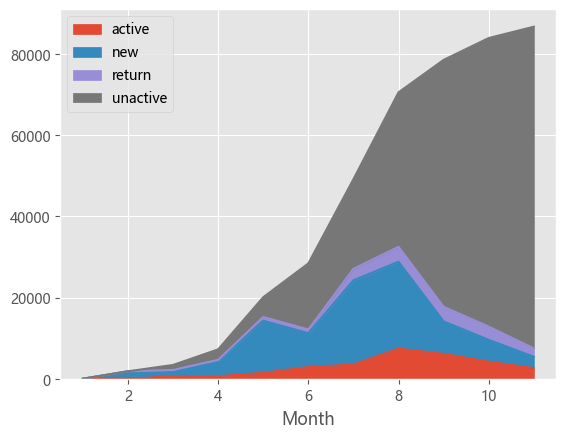

In [144]:
# 用Nan替换unreg
purchase_states_ct = purchase_states.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_states_ct.head()
purchase_states_ct.T.fillna(0).plot.area()

分析：  
1. 活跃用户在1-8月持续上升，在8-11月逐渐下降。需要采取措施确保活跃用户数量稳定
2. 在5月与7月的两次未知事件中产生了大量新用户与回流用户，但8月后均持续下降。其中回流用户在平台的重要保留目标客户，平台需要采取措施以保证用户的留存率。

#### 4. 购买周期


In [145]:
# 计算购买周期
# 使用shift函数将数据移动到一定的位置（整体向下或向右,默认值axis=0向下）
order_diff = df0.groupby(by='user_id').apply(lambda x:x['event_time']-x['event_time'].shift()) #当前订单日期 — 上一次订单日期
order_diff

user_id                    
1515915625439951872  111686                NaT
1515915625440038400  287792                NaT
                     365564   35 days 14:42:32
1515915625440051712  356498                NaT
                     356681    0 days 02:46:45
                                    ...       
1515915625514887936  419354                NaT
1515915625514888704  419362                NaT
                     419387    0 days 00:35:32
1515915625514891008  419382                NaT
1515915625514891264  419388                NaT
Name: event_time, Length: 419390, dtype: timedelta64[ns]

In [146]:
order_diff.describe()

count                        332474
mean      7 days 12:36:29.084069732
std      21 days 13:31:19.715265384
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%          0 days 00:17:53.500000
75%          2 days 09:29:24.500000
max               290 days 06:53:43
Name: event_time, dtype: object

In [147]:
# 删除所有值为0 days 00:00:00的数据
order_diff.replace(np.timedelta64(0), np.nan, inplace=True)
order_diff = order_diff.dropna()
order_diff.describe()

count                        244209
mean     10 days 05:53:08.365445172
std      24 days 14:24:26.246739582
min                 0 days 00:00:01
25%                 0 days 00:08:53
50%                 0 days 04:59:27
75%                 6 days 16:57:25
max               290 days 06:53:43
Name: event_time, dtype: object

In [148]:
order_diff.info()

<class 'pandas.core.series.Series'>
MultiIndex: 244209 entries, (1.5159156254400384e+18, 365564) to (1.5159156255148887e+18, 419387)
Series name: event_time
Non-Null Count   Dtype          
--------------   -----          
244209 non-null  timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 25.7 MB


<Axes: >

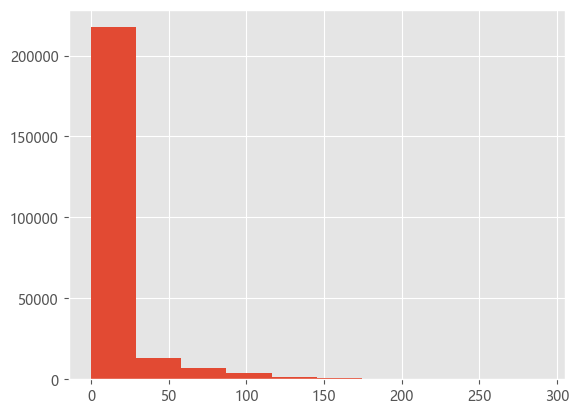

In [149]:
(order_diff/np.timedelta64(1,'D')).hist(bins=10)

分析：
1. 平均购买周期为10天6小时，且大部分用户若有重复消费，其消费周期都在6天17小时以内。
2. 小部分不活跃用户消费周期在50天以上，可以通过定期促销活动提升其消费频率，例如可在用户消费6天后赠送消费券等

#### 5. 生命周期（新老客户消费比）

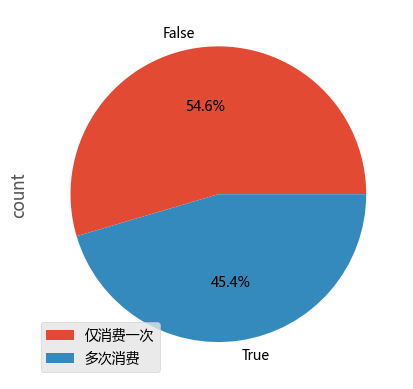

In [150]:
# 计算方式： 用户最后一次购买 — 第一次购买的日期  如果差值=0 说明用户只够买了一次
user_life = df0.groupby(by='user_id')['event_time'].agg(['min','max'])
(user_life['max'] == user_life['min']).value_counts().plot.pie(autopct='%1.1f%%') # 判断只够买一次的用户占比  格式化一位小数
plt.legend(['仅消费一次','多次消费'])

分析：
1. 有超过一半的用户仅消费了一次，需要优化运营以提高留存率

In [151]:
(user_life['max'] - user_life['min']).describe()

count                         86916
mean     28 days 18:52:05.103973952
std      53 days 23:52:23.157131047
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%          0 days 00:52:56.500000
75%         33 days 18:24:56.500000
max               319 days 05:42:43
dtype: object

分析：  
2. 用户平均生命周期为28天19小时，但中位数只有52分钟，存在大量低质量用户  
3. 有25%的用户生命周期超过33天18小时，这部分是重点关注对象，需要确保其能够成为稳定用户

Text(0, 0.5, '用户人数')

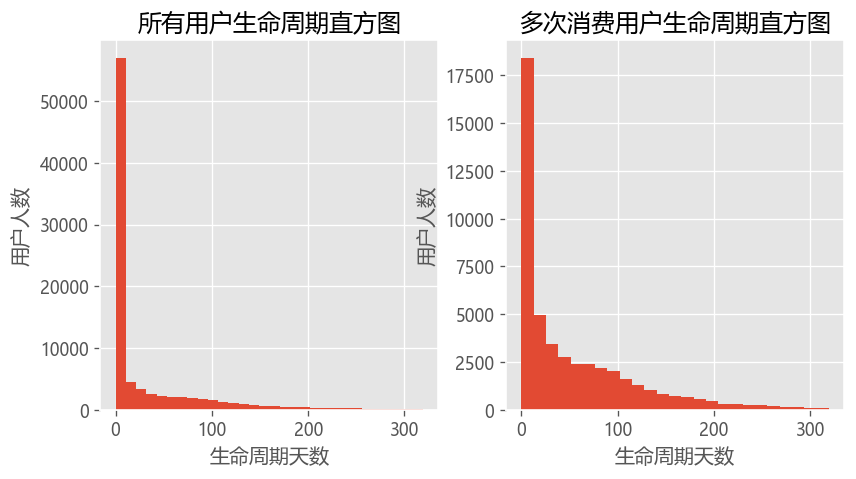

In [152]:
# 绘制所有用户生命周期直方图+多次消费
plt.figure(figsize=(8,4),dpi=120)
plt.subplot(121)
((user_life['max'] - user_life['min'])/np.timedelta64(1,'D')).hist(bins=30)
plt.title('所有用户生命周期直方图')
plt.xlabel('生命周期天数')
plt.ylabel('用户人数')

plt.subplot(122)
u_1 = (user_life['max'] - user_life['min']).reset_index()[0]/np.timedelta64(1,'D')
u_1[u_1>0].hist(bins=25)
plt.title('多次消费用户生命周期直方图')
plt.xlabel('生命周期天数')
plt.ylabel('用户人数')

分析：  
4. 对比单次与多次消费用户生命周期直方图，可知大量多次消费的用户生命周期依然过短，只有少部分用户有长期多次消费经验，属于忠诚用户。需要对其进行针对性的追踪以及营销活动，同时需要维护用户黏性。

### 六、复购率和回购率分析

#### 1. 复购率分析

定义：一定时间范围内重复购买的客户比例。  
  
计算方式：在数据所包含的11个月内，每月分别统计算购买多次的用户/总消费人数（同一天消费多次也算）  
消费者有三种：  
1.本月消费多次（复购）  
2.本月消费一次  
3.本月无消费

定义数值：  
复购： 1  
非复购且有消费：0  
无消费：NAN(不参与count计数)

<Axes: xlabel='Month'>

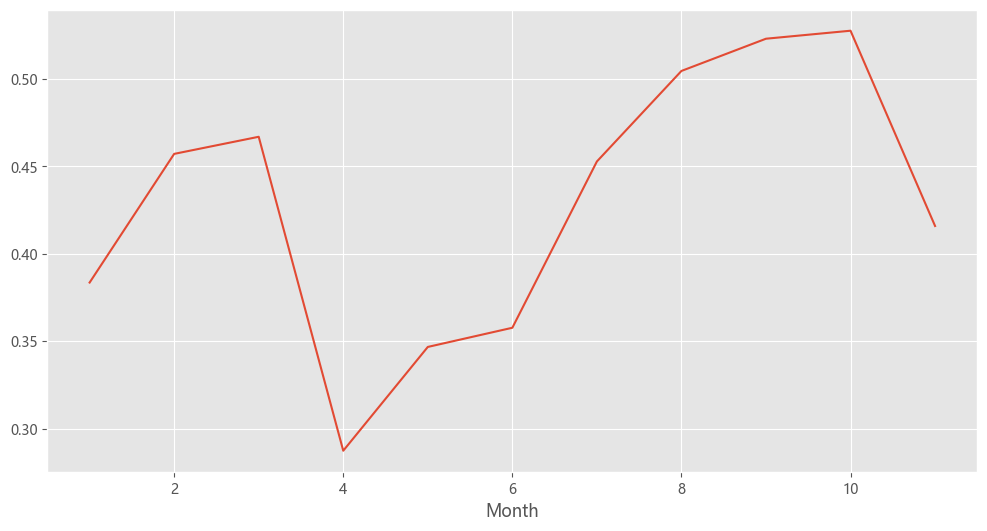

In [153]:
purchase_r = pivoted_counts.applymap(lambda x:1 if x>1 else np.NaN if x==0 else 0)

# purchase_r.sum() 复购用户人数
# purchase_r.count() 所有参与消费的用户人数
(purchase_r.sum()/purchase_r.count()).plot(figsize=(12,6))  

分析：
1. 1-3月、4-10月复购率呈现上升趋势，最高超过了50%。
2. 在4月与11月复购率剧烈下降，需要深入收集数据分析原因

#### 2. 回购率分析

定义：一个时间窗口内发生购买，在下一个时间窗口内再次发生购买的客户比例。  

计算方式： 对于每个月的所有用户，如果发生消费，则查询是否下个月发生了消费。如果下个月发生了消费则为回购用户
 

定义数值：  
1：回购用户（当前月消费了，下个月又消费了）   
0：当前月消费 下个月未消费   
nan：当前月未消费

In [154]:
def purchase_back(data):
    status = [] #存储用户回购率状态
    for i in range(1,11):
        # 当前月消费了
        if data[i] == 1:
            if data[i+1] ==1:
                status.append(1) # 回购用户
            elif data[i+1] == 0:
                status.append(0) # 下个月未消费
        # 当当前月未消费
        else:
            status.append(np.NaN)
    status.append(np.NaN)  # 填充最后一列数据
    return pd.Series(status,df_purchase.columns)
purchase_b = df_purchase.apply(purchase_back,axis=1)
purchase_b.head()

Month,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1515915625439951872,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1515915625440038400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
1515915625440051712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1515915625440099840,NaN,NaN,NaN,NaN,NaN,1,0,NaN,1,0,NaN
1515915625440121600,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN


Text(0, 0.5, '人数')

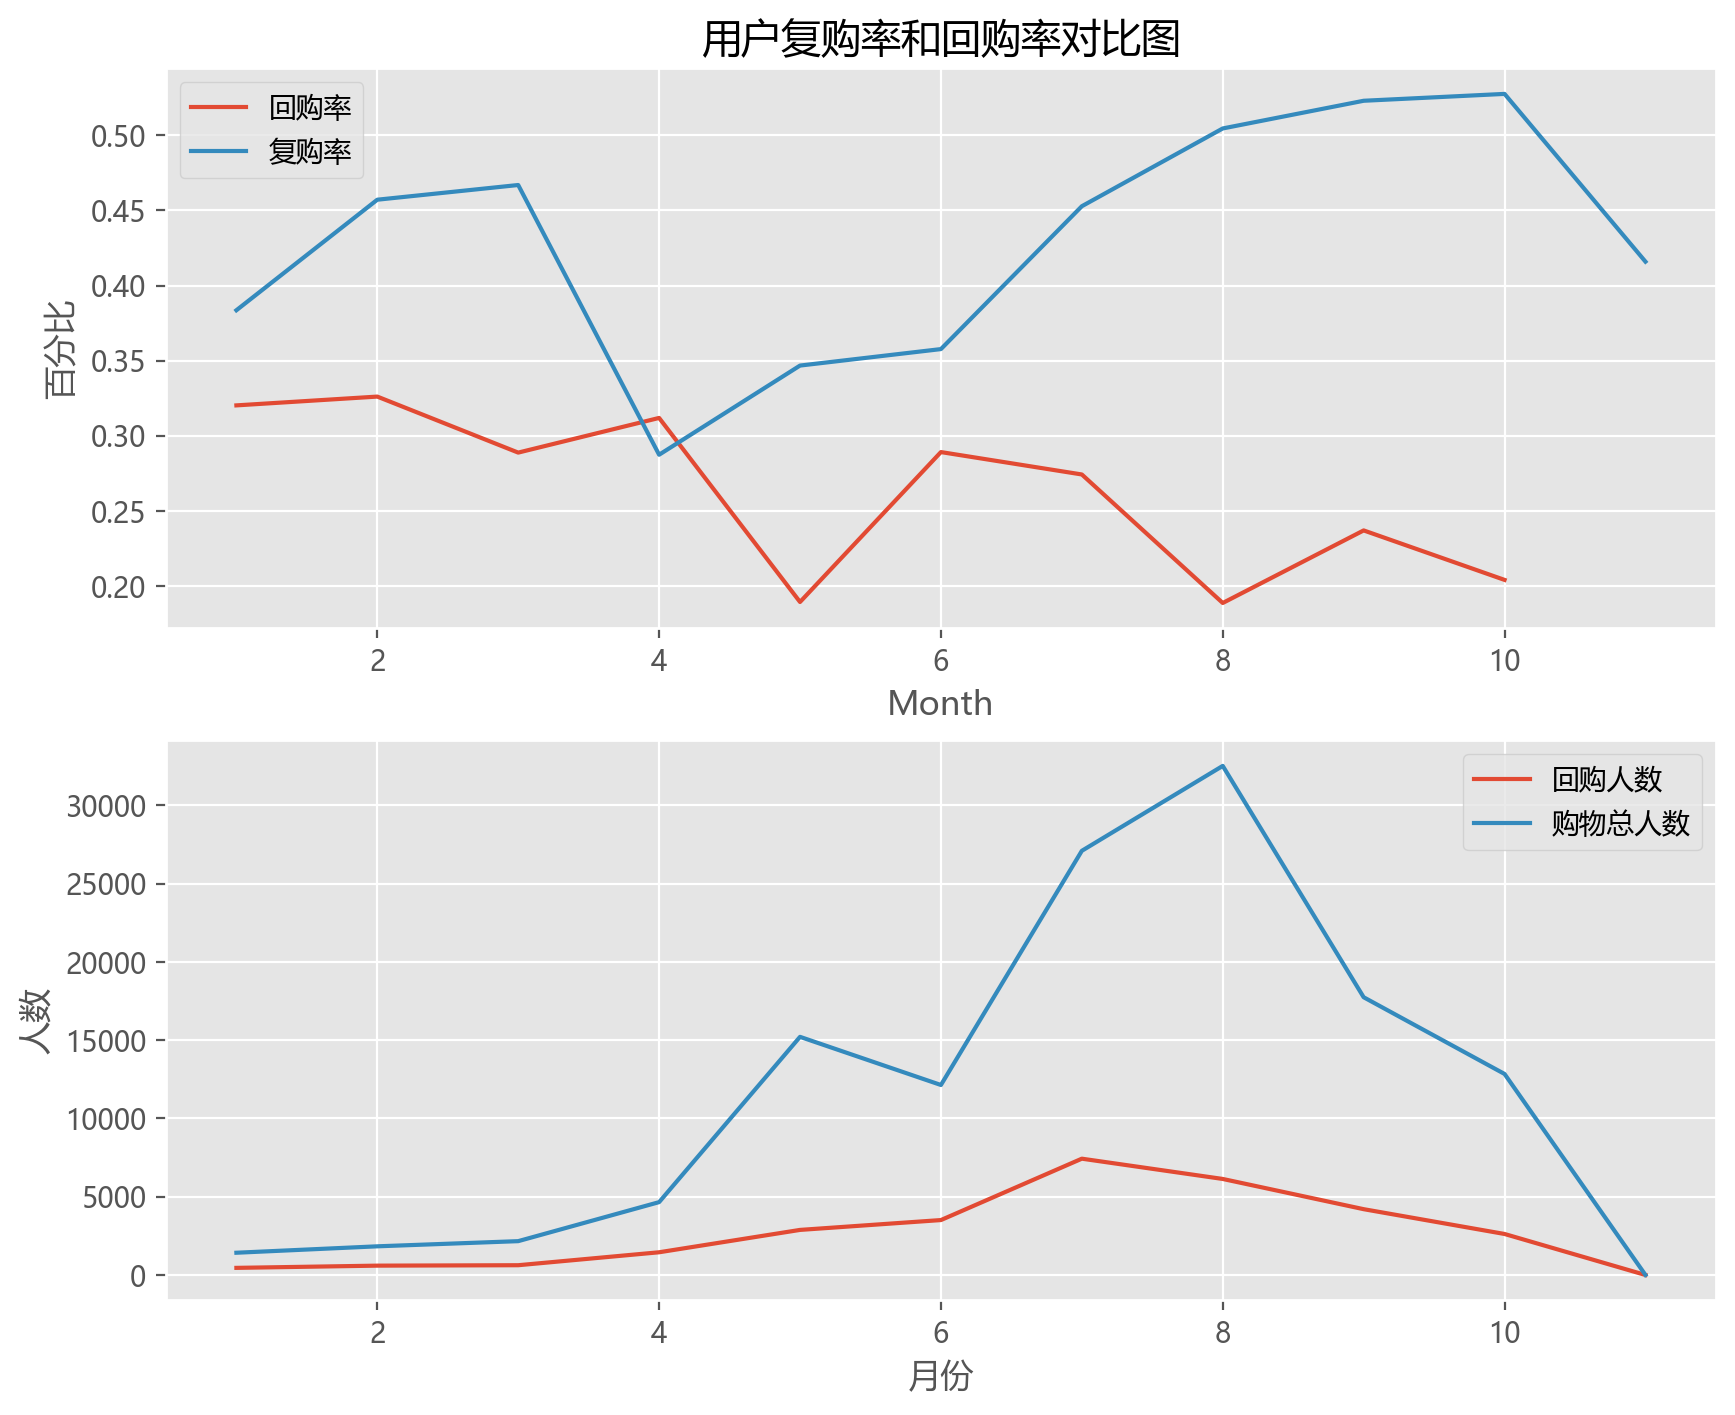

In [155]:
# 回购率可视化
plt.figure(figsize=(10,8),dpi=200)
plt.subplot(211)
# 回购率
(purchase_b.sum()/ purchase_b.count()).plot(label='回购率')
# 复购率
(purchase_r.sum()/purchase_r.count()).plot(label='复购率')
plt.legend()
plt.ylabel('百分比')
plt.title('用户复购率和回购率对比图')


# 回购人数与购物总人数
plt.subplot(212)
plt.plot(purchase_b.sum(),label='回购人数')
plt.plot(purchase_b.count(),label='购物总人数')
plt.legend()
plt.xlabel('月份')
plt.ylabel('人数')

分析：  
1. 回购率整体呈下降趋势，且几乎一直低于复购率。可能客户更加倾向于尝试新的竞争对手的服务，或者对平台的服务没有足够的满意度。需要加强与客户的沟通和反馈，并且进行深入市场研究和竞争分析。
2. 回购率在4月与8月有剧烈下降。已知这两个时间点附近发生了平台引入大量新客户的事件，说明平台需要改善留存用户的措施。

### 七、结论

1. 用户整体消费趋势分析
    1. 上半年的月消费总金额较低，于6月开始有剧烈增长并于8月达到峰值，年末再次下降。可能平台在暑期有促销活动，也可能与季节性因素等等相关。具体的成因分析需要更多有关该电商平台的业务信息。
    2. 广东、北京、上海的消费相较于其他地区十分突出。可以以此为起点依据更多平台的数据信息深挖潜在变量，以帮助平台优化区域定位和市场拓展策略；还可以针对高消费的区域加大市场投入、提升推广力度、进行本地化适配等。
    3. 手机、冰箱、笔记本电脑、耳机、电视作为前五类别，可以帮助平台建立用户画像。在娱乐、办公、音频体验和家居产品领域，平台首先需要确保该类别业务链的稳定性，同时可以考虑扩大产品种类、加强这产品宣传和推广与促销活动以吸引更多的潜在消费者
    4. 与冰箱相比，同样是大型家居类产品的空调、桌子、抽油烟机等销量仅为前者一半左右。需要对原因进行更深入的分析，可能与市场的竞争与饱、平台选择的的合作品牌等因素相关联。
2. 用户个体消费分析
    1. 每位用户的消费总额平均值为1127，中位数为472，属于右偏分布。
    2. 75%分位数为1151（与平均数相近）有1/4的高额消费用户承担了77%的总消费额
    3. 前88.3%的用户贡献了40%的金额，后11.7%的高消费用户贡献了60%的金额。少数用户贡献了平台的主要现金流，需要重点关注
3. 用户消费行为
    1. 首购时间：新用户流入在1月至4月下旬很少，在5-6月发生了一次小增长，随后6-7又有相当幅度的下降。随后在7月至8月中旬有一次爆发式的用户流入，并且在之后逐渐降低。数据变化剧烈、人为痕迹明显，应该不是自然因素，推测平台在5月和7月采取了某些措施。
    2. 最后一次购买时间：
        1. 在数据截止前（11月底）有突出峰值，说明大概率存在可观数量的用户在持续消费直到数据截止。判断平台有一批忠诚客户
        2. 大量客户最后一次消费发生在5-6月和7-8月的两次新用户爆发式流入的事件中，说明这两次次事件并未创造足够的用户黏性、需要采取措施。
    3. 用户分层
        1. 构建RFM模型
        2. 新&老、活跃、回流用户分析  
            1. 活跃用户在1-8月持续上升，在8-11月逐渐下降。需要采取措施确保活跃用户数量稳定
            2. 在5月与7月的两次未知事件中产生了大量新用户与回流用户，但8月后均持续下降。其中回流用户在平台的重要保留目标客户，平台需要采取措施以保证用户的留存率。 
    4. 购买周期
        1. 平均购买周期为10天6小时，且大部分用户若有重复消费，其消费周期都在6天17小时以内。
        2. 小部分不活跃用户消费周期在50天以上，可以通过定期促销活动提升其消费频率，例如可在用户消费6天后赠送消费券等
    5. 生命周期（新老客户消费比）
        1. 有超过一半的用户仅消费了一次，需要优化运营以提高留存率
        2. 用户平均生命周期为28天19小时，但中位数只有52分钟，存在大量低质量用户
        3. 有25%的用户生命周期超过33天18小时，这部分是重点关注对象，需要确保其能够成为稳定用户
        4. 根据多次消费用户生命周期直方图，可知大量多次消费的用户生命周期依然过短，只有少部分用户有长期多次消费经验，属于忠诚用户。需要对其进行针对性的追踪以及营销活动，同时需要维护用户黏性。
4. 复购率和回购率分析
    1. 复购率分析
        1. 1-3月、4-10月复购率呈现上升趋势，最高超过了50%。
        2. 在4月与11月复购率剧烈下降，需要深入收集数据分析原因
    2. 回购率分析
        1. 回购率整体呈下降趋势，且几乎一直低于复购率。可能客户更加倾向于尝试新的竞争对手的服务，或者对平台的服务没有足够的满意度。需要加强与客户的沟通和反馈，并且进行深入市场研究和竞争分析。
        2. 回购率在4月与8月有剧烈下降。已知这两个时间点附近发生了平台引入大量新客户的事件，说明平台需要改善留存用户的措施。